In [1]:
import requests, json, urllib3,re, sys, jieba, operator, collections, math
from bs4 import BeautifulSoup
from six import u
from udicOpenData.stopwords import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yuga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Yuga\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Yuga\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Yuga\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yuga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
urllib3.disable_warnings()
payload = {'from':'/bbs/Gossiping/index.html','yes':'yes'}
url = 'https://www.ptt.cc/bbs/Gossiping/index.html'
rs = requests.session()
res = rs.post('https://www.ptt.cc/ask/over18',data=payload)

In [3]:
threshold =5000
politic_name = ['柯文哲','柯p','北市長','柯媽','陳佩琪','柯P','柯']
p_name = '柯'

In [4]:
url = 'https://www.ptt.cc/bbs/Gossiping/index.html'
path_output = '../asset/gossip_output.json'
path_kop = '../asset/gossip_kop.json'
path_pdf = '../output/gossip.pdf'
path_link = '/bbs/Gossiping/'


# url = 'https://www.ptt.cc/bbs/HatePolitics/index.html'
# path_output = '../asset/hatepolitics_output.json'
# path_kop = '../asset/hatepolitics_kop.json'
# path_pdf = '../output/hatepolitics.pdf'
# path_link = '/bbs/HatePolitics/'

In [5]:
def check_name(keyword,content):
    for word in keyword:
        if word in content:
            return 1
        else:
            return 0
        
def sort_dict(dict):
    sorted_x = sorted(dict.items(), key=lambda kv: kv[1], reverse=True)
    sorted_dict = collections.OrderedDict(sorted_x)
    
    return list(sorted_dict.items())

# 開爬

In [6]:
article_count = 0
page = 0
with open(path_output, 'w',encoding = 'utf8')as f:
    f.truncate(0)
f.close()
while article_count < threshold:
    res = rs.get(url, verify=False)
    soup = BeautifulSoup(res.text)
    nextpageurl = 'https://www.ptt.cc'+soup.find_all(attrs = {'class':'btn wide'})[1]['href']#下一頁以及上一頁url
    print('current url:',url)
    print('next url:',nextpageurl)
    for article in soup.find_all('div', class_='r-ent'):
#         print('aaaaaaaaaaaa')
#         print(article)
        push_content = []
        if article_count >= threshold:
            break
        meta = article.find(class_='title')
        text = meta.find('a')
        if(text is not None):
            title = text.text
            if '公告' not in title:
            
                link = meta.find('a')['href']
                date = article.find('div', 'date').getText()
                author = article.find('div', 'author').getText()
                article_id = link.replace(path_link,'').replace('.html','')

                #蒐集內文資料
                contenturl = "https://www.ptt.cc" + link
                res = rs.get(contenturl)
                soup = BeautifulSoup(res.text, 'lxml')

                main_content = soup.find(id="main-content")
                metas = main_content.select('div.article-metaline')
                
                #去除main_content中非內文部分
                for meta in metas:
                    meta.extract()
                for meta in main_content.select('div.article-metaline-right'):
                    meta.extract()
                pushes = main_content.find_all('div', class_='push')
                for push in pushes:
                    push.extract()
                try:
                    ip = main_content.find(text=re.compile(u'※ 發信站:'))
                    ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
                except:
                    ip = "None"
                filtered = [ v for v in main_content.stripped_strings if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--'] ]
                expr = re.compile(u(r'[^\u4e00-\u9fa5\u3002\uff1b\uff0c\uff1a\u201c\u201d\uff08\uff09\u3001\uff1f\u300a\u300b\s\w:/-_.?~%()]'))
                for i in range(len(filtered)):
                    filtered[i] = re.sub(expr, '', filtered[i])

                filtered = [_f for _f in filtered if _f]  # remove empty strings
                filtered = [x for x in filtered if article_id not in x]  # remove last line containing the url of the article

                #蒐集留言(存入list)    
                for push in pushes:
                    try:
                        push_content.append(push.find('span',class_='push-content').get_text().encode(sys.stdin.encoding, "replace").decode(sys.stdin.encoding))
                    except Exception:
                        push_content.append('')
                        print('error')
                        pass


                #蒐集內文
                content = ' '.join(filtered)
                content = re.sub(r'(\s)+', ' ', content)



                article_count += 1
                #將蒐集到的資料儲存成json格式
                data = {'number':article_count,
                        'author':author,
                        'title':title,
                        'content':content,
                        'comment':push_content
                        }
                #印出資料、儲存至json
                with open(path_output, 'a',encoding = 'utf8')as f:
                    json.dump(data,f, ensure_ascii=False,indent = 4, separators=(',', ': '))
                f.close()
                print("count:",article_count,":",title, date, author)  # result of setp-3
                #print(content)
                #print(main_content.extract())
                #print(data)
            
            
            
    url = nextpageurl
    page+=1
    print("================page ",page,' ===================')
    

current url: https://www.ptt.cc/bbs/Gossiping/index.html
next url: https://www.ptt.cc/bbs/Gossiping/index39179.html
count: 1 : [問卦] 高雄撐的過這波梅雨鋒面嗎？  5/01 PoorHunter
count: 2 : [問卦] 畫家梵谷算不算魯蛇？有掛無?  5/01 muskoxenyes
count: 3 : Re: [問卦] 28歲重唸大一文組能吃學生妹？  5/01 bache
count: 4 : Re: [問卦] 正妹的朋友都是正妹?  5/01 diffuse
count: 5 : Re: [爆卦]最新民調:藍營 賴清德32.6％,蔡英文12.5％  5/01 spidina
count: 6 : Re: [新聞] 綜所稅申報現場直擊 民眾：降稅真的有感  5/01 ulycess
count: 7 : [問卦] 真的有大學生跟教授上床嗎？  5/01 ht91008
count: 8 : [問卦] 有劍為兵 用者在人 何解？  5/01 e584886401
count: 9 : Re: [新聞] 基本薪資漲幅超過馬政府！蔡英文：照顧  5/01 goodman5566
count: 10 : Re: [新聞] 蔡英文宣布基隆河流域 土地開發管制解禁  5/01 feng19890809
count: 11 : [爆卦] 嘉義市立委初選完~寶特瓶  5/01 Kelmar
count: 12 : [問卦] 有沒有蜜蜂來陽台築巢的八卦？  5/01 chiao130
count: 13 : Re: [問卦] 男生如何解決褲襠凸出的問題？  5/01 santan
count: 14 : [問卦] 5/1勞動節放假是慶祝令和元年嗎？  5/01 papaganono
count: 15 : [新聞] 留言酸羅友志 王奕凱：我相信你不是自私  5/01 LDMisshit
count: 16 : Re: [爆卦]最新民調:藍營 賴清德32.6％,蔡英文12.5％  5/01 santisuk
count: 17 : Re: [爆卦] 小組長擴權起來，八卦、表特獨裁時代來臨  5/01 BKD858
count: 18 : [新聞

count: 141 : [問卦] 一中街有什麼好吃的？？  5/01 f77928
count: 142 : [問卦] 高中時的女友跟大學同學在一起  5/01 wurara22
count: 143 : [新聞] 雙子星中資案 黃國昌爆「南海控股」接受  5/01 xhungx
count: 144 : [新聞] 基本薪資漲幅超過馬政府！蔡英文：照顧  5/01 TWOOOOOOOOOO
count: 145 : [問卦] 一天幾杯手搖杯?  5/01 kiwidoit
count: 146 : [問卦] 為什麼不把霸凌壞小孩送進軍隊再教育  5/01 c52chungyuny
count: 147 : [問卦] 聽說安博盒子有復仇者4了？真的嗎？  5/01 a1106abc
count: 148 : Re: [新聞] 報稅系列／首日現場直擊！減稅大紅包民?1  5/01 samitsai
count: 149 : [問卦] 為什麼德國的大學 排名都很爛??  5/01 eeewwweeewww
count: 150 : Re: [問卦] 為何沒人說瘦宅噁心？  5/01 trylin
count: 151 : [新聞] 士林雙屍命案》為撫養權下殺手？伊拉克籍  5/01 s1777001
count: 152 : Re: [問卦] 男生如何解決褲襠凸出的問題？  5/01 redDest
count: 153 : [問卦] 是不是只有成為強者才能獲得美國的尊重?  5/01 gn1384181
count: 154 : Re: [問卦] 男生如何解決褲襠凸出的問題？  5/01 CavendishJr
count: 155 : Re: [新聞] 雙子星中資案 黃國昌爆「南海控股」接受中國10億補貼  5/01 arsonlolita
count: 156 : [新聞] 疑酒駕肇逃撞機車害命 死者妻：還我丈夫  5/01 linuxmint
count: 157 : [臉書] 謝志偉  5/01 xchangex
count: 158 : [問卦] 簽名檔放動漫蘿莉妹圖都是哪種人  5/01 ph98
count: 159 : Re: [新聞] 雙子星中資案 黃國昌爆「南海控股」接受  5/01 deanh
================page  8  =

count: 280 : Re: [問卦] 悠仁準天皇是不是世界最爽的國中生？  5/01 buslover
count: 281 : [問卦] 黑人學中文會怎麼罵”幹你娘”？  5/01 khfcgmbk
count: 282 : Re: [新聞] 口號再+1！ 韓國瑜揚言要征服宇宙  5/01 ebod221
count: 283 : [問卦] 電腦螢幕的最佳體驗是幾吋大小  5/01 Bright
count: 284 : Re: [問卦] 有沒有線上娛樂城詐騙的八卦  5/01 ElizabethXIV
count: 285 : [問卦] 蘿莉勞工今天有得休假嗎？  5/01 SaintSeven
count: 286 : Re: [新聞] 上櫃公司好薪酸 股價200元員工薪資僅38萬  5/01 unclefucka
count: 287 : Re: [新聞] SANA「官方IG告別平成」南韓網友氣炸  5/01 imjungyi923
count: 288 : Re: [爆卦] 南韓總統要新天皇記得過去的戰爭所帶來的  5/01 mean
count: 289 : [新聞] 幸福盟籲落實公投結果：婚姻一男一女  5/01 skinoren
count: 290 : [問卦] 對台妹來說父母給的200萬白手起家的男人  5/01 feng19890809
count: 291 : [問卦] 發文附圖好嗎  5/01 q5123123
count: 292 : [新聞] 又遲到！韓國瑜世新演講延後1小時  5/01 train60125
count: 293 : [新聞] 又有人留言嗆「韓國瑜必死」高市警朝預備  5/01 XXXXGGYY
================page  15  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39165.html
next url: https://www.ptt.cc/bbs/Gossiping/index39164.html
count: 294 : Re: [新聞] 超級劇透！《復仇者聯盟4》導演親自解謎  5/01 xanthippe
count: 295 : [問卦] 為何委國政府不逮捕或刺殺瓜伊多?  5/

count: 421 : [新聞] 《音速小子》真人版預告出爐　電玩迷崩  5/01 yuzukineko
count: 422 : [問卦] 復仇者聯盟4給王晶拍會怎樣  5/01 hopeskyme
count: 423 : [問卦] 勞工放假只能嗆學生一次是不是很可悲  5/01 snoe1119
count: 424 : [問卦] 人生勝利組現在在幹嘛？  5/01 Dreampen
count: 425 : [問卦] 娶到日本天皇公主可以少奮鬥幾年？  5/01 gogoeggs
count: 426 : [問卦] 哪裡可以學到正宗截拳道？  5/01 mianbowhow
count: 427 : [問卦] 有人跟我坦承他要搶銀行 點解???  5/01 HidekiRyuga
count: 428 : [新聞] 放寬藝文採購不受採購法限制 文化部：更  5/01 a1e
count: 429 : Re: [新聞] 促轉會實現尋父願望！布農族人在六張犁貳  5/01 ThisisLongID
================page  22  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39158.html
next url: https://www.ptt.cc/bbs/Gossiping/index39157.html
count: 430 : [問卦] 韓國物價根本不高的八卦  5/01 BorrasH
count: 431 : [問卦] 欸欸 二手板484一堆奇葩啊？  5/01 aigis
count: 432 : [新聞] 韓國瑜到底哪裡好？他曝關鍵7字!  5/01 yiyji
count: 433 : [問卦] 世界上最神秘的五樓─北韓羊角島酒店  5/01 iqeqicq
count: 434 : [問卦] 台男覺得現在的日本公主算漂亮嗎？  5/01 sodistrues
count: 435 : [問卦] 住在新北永和是什麼感覺？  5/01 lauwei
count: 436 : [新聞] 當中共間諜換錢 中情局前華裔官員或認罪  5/01 eeth
count: 437 : [問卦] 勞工勞動節放假，老師教師節不放假？  5/01 

current url: https://www.ptt.cc/bbs/Gossiping/index39151.html
next url: https://www.ptt.cc/bbs/Gossiping/index39150.html
count: 563 : [新聞] 賴清德批民進黨少數人決定 蔡英文反駁：  5/01 ArimuraChika
count: 564 : Re: [問卦] 台灣街景不能跟日本街景一樣？  5/01 nico5516
count: 565 : [問卦] 獨角鯨的角是幹嘛用的?  5/01 buke
count: 566 : Re: [新聞] 台海擦槍走火？雙方戰機相遇台軍意外發射  5/01 Gjoy
count: 567 : [問卦] 外匯C300是CP值王嗎？  5/01 leona12
count: 568 : [問卦] 八咫鏡現在怎麼了  5/01 Kulapica
count: 569 : Re: [新聞] 檢察官林俊佑撂警衝幼兒園訊問 職務法庭  5/01 cherrywo
count: 570 : Re: [新聞] 「征服宇宙」是維多利亞學校校訓  5/01 maudu
count: 571 : [新聞] 美女警苦練舞技為宣導治安　與高中熱舞  5/01 shaoye
count: 572 : [新聞] 友達在林口架設印刷式OLED實驗線  5/01 BorrasH
count: 573 : [問卦] 什麼時候要給早餐店奶茶頒醫學供獻獎  5/01 cavern
count: 574 : [新聞] 躲在暗處專攔老人 警長「密令解密」感動  5/01 cisbpmtw
count: 575 : [問卦] 司法官若被免職 還能去當律師 是不是笑話?  5/01 syearth
count: 576 : [新聞] 韓國瑜今到世新演講！校友：此生最棒英文  5/01 chungwez
count: 577 : [問卦] 工友能放勞動節但約聘雇卻沒有?  5/01 paiopapa
count: 578 : [問卦] 有沒有明仁現在在想什麼的卦  5/01 dbidiot
count: 579 : Re: [問卦] 台灣人都不會怕被南韓幹掉嗎?  5/01 vikk33
count: 580 : [問卦] 幻視是不是復仇者裡

count: 700 : [問卦] 穿西裝背背包會很怪嗎？  5/01 AlarmBell
count: 701 : [問卦] 有沒有line封鎖好友的八卦？  5/01 gotopark
count: 702 : [問卦] 有沒有台灣拳王-周正志的八卦?  5/01 EDGEo93353
count: 703 : [臉書] 賴坤成 員工領5000韓國瑜自己領92.5萬  5/01 jenlei
count: 704 : [爆卦] 郭台銘:北京要聽我的  5/01 BorrasH
count: 705 : Re: [爆卦] 美FDA通過iQOS加熱菸銷售審查 打臉政府  5/01 paulabxz123
count: 706 : Re: [新聞] 韓流神話破滅？韓國瑜：我是各方狙擊的  5/01 Wii
count: 707 : [問卦] 中華海域漁業権益協会 有人聽過嗎?  5/01 neoma
count: 708 : Re: [新聞] 扁案重啟審理？瑞士發函法務部催處理3億  5/01 ILANsamurai
count: 709 : Re: [問卦] 有沒有可利亞有多好吃的八卦...?  5/01 ivorysoap
count: 710 : [新聞] 陳致中海外「億元帳戶」曝光！扁家5弊案  5/01 diefishfish
count: 711 : Re: [新聞] 陳致中海外「億元帳戶」曝光！扁家5弊案  5/01 osalucard
count: 712 : Re: [問卦] 有沒有可利亞有多好吃的八卦...?  5/01 Lailungsheng
count: 713 : Re: [新聞] 快訊／轟蔡英文自我感覺良好　馬英九：  5/01 freeclouds
count: 714 : [問卦] 天皇是日本強大的原因嗎？  5/01 skylin
count: 715 : Re: [臉書] 賴坤成 員工領5000韓國瑜自己領92.5萬  5/01 rote
count: 716 : [問卦] 漢朝和羅馬尬一場誰會贏？  5/01 AetherG
count: 717 : [新聞] 要當B2轟炸機飛行員？你得連續30小時駕駛  5/01 F16V
================page  37  ===================
curren

count: 839 : [問卦] 送這個司馬懿女裝算羞辱嗎  5/01 CavendishJr
count: 840 : [問卦] 令和元年第一天早安  5/01 friedrich
count: 841 : [新聞] 北農特別獎金 員工拿五千韓國瑜領數十萬   5/01 abramtw
count: 842 : [問卦] 現在想叫外送早餐 可以叫哪家  5/01 FL5566
count: 843 : [問卦] 欸 勞動節下大雨 代表?  5/01 wilson5566
count: 844 : [新聞] 南安小熊搭直升機 野放卓溪山區  5/01 wwf0322
count: 845 : [問卦] 美國隊長守得住街亭嗎？  5/01 tony880515
count: 846 : Re: [新聞] 受韓流重創？鬧區名店再倒2家…高雄人：  5/01 deanh
count: 847 : [新聞] 麻衣又爆離婚危機！起底王泉仁新歡 連王  5/01 ccf52881
count: 848 : Re: [新聞] 就在我們有生之年內！　NASA警告「小行星  5/01 cloud72426
count: 849 : [新聞] 王的預言竟成真？花蓮王回歸將選立委  5/01 chun0303
================page  44  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39136.html
next url: https://www.ptt.cc/bbs/Gossiping/index39135.html
count: 850 : [問卦] 下大雨妹子還穿薄紗？  5/01 tsukiyomi157
count: 851 : [新聞] 16億遺產稅入公庫 他讓彰化貧鄉二度致富  5/01 agico
count: 852 : [問卦] 現在這個時間上班仔不會亂噓了吧？  5/01 iamgaylan
count: 853 : Re: [問卦] 館長反對韓國瑜和KMT立委提出的自經區！  5/01 limitex
count: 854 : [新聞] 離婚後戶頭竟只剩360元　夫提分配夫妻剩  5/01 Eliphalet
count: 855 : Re: 

count: 980 : Re: [新聞] 中國五星旗滿街繞 網友反感嗆柯：你該做  5/01 foreverthink
count: 981 : [問卦] 令和的第一尻該看哪位比較好  5/01 lycs0908
count: 982 : [問卦] 早上蛹迷還是箭迷會擠爆廁所？  5/01 TSMConduty
count: 983 : [問卦] 小蘭都怎麼叫柯南吃飯？  5/01 wang1b
count: 984 : [問卦] 台灣最marvel的事件484遊樂園的花身美人?  5/01 pizzafan
count: 985 : [問卦] 根據質量守恆時光機484不可能被發明啊?  5/01 Qoo20811
count: 986 : Re: [爆卦] 台男其實真該跟女生學學  5/01 D122
count: 987 : [問卦] 今天媽咪要買什麼呢？  5/01 hhoo32
count: 988 : [問卦] 館長反對韓國瑜和KMT立委提出的自經區！  5/01 wangakechi
count: 989 : [問卦] 國家地理頻道封面放蟑螂?  5/01 paula5971
count: 990 : [問卦] 要聽wu-tang clan得從哪入門?  5/01 jezzy30735
count: 991 : [問卦] 母親節到底要吃哪家把費才爽？  5/01 iamgaylan
count: 992 : [新聞] 王浩宇跳針傳簡訊　遭潘恆旭「封鎖好友」  5/01 owlcity1169
count: 993 : [新聞] 政院修正天災假條文 熱帶低壓將比照颱風  5/01 kevinqazwsx
count: 994 : [問卦] 有沒有川流不息的八卦?  5/01 lycs0908
count: 995 : [問卦] 30歲還是包莖處男是什麼感覺  5/01 RLAPH
count: 996 : [問卦] 請問高雄現在可以用魯肉飯交易嗎？  5/01 foreverthink
================page  52  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39128.html
next url: https://www.ptt.cc

count: 1120 : [問卦] 動漫店怎麼存活下來的  5/01 lianpig5566
count: 1121 : [新聞] 以2008年黨內廝殺為戒 賴清德：我不犯蘇  5/01 nightwing
count: 1122 : [問卦] 馬雲為什麼要退位  5/01 bubblebeauty
count: 1123 : [問卦] 八卦理組484應該要支持簡體字？  5/01 iphone87
count: 1124 : [問卦] 出 門 不 帶 手 機 是 什 麼 心 態 ？  5/01 Dinenger
count: 1125 : Re: [問卦] 有台灣川普的掛嗎  5/01 GA389434
count: 1126 : [問卦] 平成最強動漫反派是誰？  5/01 YHOTV4096
count: 1127 : [問卦] 中國人說愛國但不愛黨是什麼邏輯  5/01 hmenri
count: 1128 : [問卦] 復仇者聯盟誰的人氣最高  5/01 kiske011
count: 1129 : [問卦] 牆壁裡有聲音  5/01 laser789
================page  59  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39121.html
next url: https://www.ptt.cc/bbs/Gossiping/index39120.html
count: 1130 : [問卦] 最近好像沒有甚麼新加坡電影?  5/01 mimi1020b
count: 1131 : [問卦] 薩諾斯vs一拳超人誰會贏？  5/01 FAT32
count: 1132 : Re: [新聞] 沈富雄要郭台銘說明：工人為何跳樓  5/01 foreverthink
count: 1133 : [問卦] 為何全聯人手永遠不足?  5/01 KSHLO
count: 1134 : [問卦] 福利熊跟湯姆熊跑步，誰贏???  5/01 kobe30732
count: 1135 : Re: [爆卦] 韓國瑜逐字稿-如何使台灣安全及統獨分析  5/01 aragorn747
count: 1136 : [問卦] 有沒有人重來沒重考過？  5/0

count: 1260 : [問卦] 急！！「阿里嘎多」是什麼意思？ 20點~  4/30 rrr0832
count: 1261 : Re: [問卦] 明年台灣人該支持共和黨還民主黨？  4/30 LoveWin7
count: 1262 : [問卦] 對岸中國人說令和年 會被懷念嗎?  4/30 MinamiHinata
count: 1263 : Re: [新聞] 彭文正《政經》停播7天又復活 網友：檢舉  4/30 jack096
count: 1264 : [問卦] 在火車上看出包王女要多大的恥力？  4/30 justwe5566
================page  66  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39114.html
next url: https://www.ptt.cc/bbs/Gossiping/index39113.html
count: 1265 : [問卦] 台灣流出怎麼那麼多  4/30 loserfatotak
count: 1266 : [新聞] 印度軍方稱發現雪人大腳印 長81公分寬38  4/30 Gotham
count: 1267 : Re: [問卦] 藥學系vs 高考、國營？  4/30 asddffG
count: 1268 : [問卦] 皮條丘連長失去戰鬥能力，萬華壁球亞軍  4/30 puretruthson
count: 1269 : [問卦] 二乃是不是平成第一婊子?  4/30 qwaszx012
count: 1270 : [新聞] 高雄文化局招志工擺烏龍 兼職、長期工讀  4/30 sky52442009
count: 1271 : Re: [新聞] 郭台銘曝參選理由：政府讓年輕人坐以待斃  4/30 NARUTO
count: 1272 : [新聞] 迎接令和時代　蔡英文推特準時送祝福  4/30 proprome
count: 1273 : Re: [問卦] 長輩都覺得韓國瑜會做事？  4/30 Lumial020
count: 1274 : [新聞] 查票辛酸史 曾被咒下地獄  4/30 tr291161
count: 1275 : [新聞] 賴清德舅舅童永挺蔡英文：希望妳再一次

count: 1398 : Re: [爆卦] 韓國瑜逐字稿-如何使台灣安全及統獨分析  4/30 COOLBILL
count: 1399 : [新聞] 習近平騎劫五四運動精神　將愛國愛黨綑綁  4/30 worldjournal
count: 1400 : [新聞]逼土豪棄坑遊戲！他直播刪「價值5000萬」  4/30 pl132
count: 1401 : [問卦] 這幾年  4/30 Racing5566
count: 1402 : [問卦] 中華民國連廁所都不會設計的八卦？  4/30 oftisa
count: 1403 : Re: [新聞] 新普科技:持續經營大陸市場 堅持九二共識  4/30 XDDDDDDDDDD
count: 1404 : [新聞] 「IKEA新店店」餐廳有河濱公園景觀 5月16  4/30 tony900735
count: 1405 : Re: [問卦] 研發吃海水的水稻有搞頭嗎？  4/30 shenhsu
count: 1406 : [問卦] 小當家跟嘟嘟是不是吃太多，體脂飆高啊？  4/30 littlesweety
count: 1407 : [新聞] 韓國瑜：論壇中會表述如何快速衝高雄經濟  4/30 sql86
count: 1408 : [問卦] 平成要結束了跟台灣人有什麼關係      4/30 Nujabes
count: 1409 : [問卦] OLG裡最強的是不是死靈法師跟刺客?  4/30 csi9507121
count: 1410 : [問卦] 賭p幣變大富翁是運氣還是實力  4/30 miss80423
count: 1411 : [問卦] 以前同學說要跟我分享一個賺錢的機會  4/30 dudeboy
count: 1412 : [新聞] 逆轉 北市府勝訴確定 大巨蛋復工受挫  4/30 nawabonga
count: 1413 : [問卦] 出發總有個方向?  4/30 odd5566
count: 1414 : [問卦] 又要跨年了？  4/30 shala
count: 1415 : [問卦] ptt是真的都剩老人喔  4/30 gogoeggs
count: 1416 : [新聞] 疾呼改革迫切！韓國瑜：政府要「做牛做馬  4/30 ilbonchimmol
count: 1417 : 

count: 1536 : [問卦] 詐騙V.S.直銷  4/30 superpaden
count: 1537 : [新聞] 30歲以下年輕人購屋 占比最高的是高雄市  4/30 AzurElsa
count: 1538 : [問卦] 胖老爹開始倒了嗎？  4/30 torrest
count: 1539 : [問卦] 有沒有智齒的功能的八卦？  4/30 gotopark
count: 1540 : [新聞]「離島」遭下架？Hebe：解釋過了  4/30 yushenglu
count: 1541 : [問卦] 朱立人  4/30 sars7125889
count: 1542 : [問卦] 平成最後の晩餐?  4/30 proprome
count: 1543 : [問卦] 張立東是不是熬出頭了  4/30 dream0402
count: 1544 : Re: [問卦] 美女是不是通常國小就看得出來？  4/30 feng19890809
count: 1545 : [問卦] 如何學習彈指  4/30 kopuck
count: 1546 : [問卦] 做愛發電是否可行？  4/30 mojojojo5217
count: 1547 : [問卦] 復4驚奇隊長是不是宇宙最快  4/30 rs6677
count: 1548 : [新聞] 暗藏貨櫃 高雄關查獲1萬餘公斤中國香菇  4/30 q1qaz2
count: 1549 : [問卦] 天皇%%%的時候也會有要守的規範嗎？  4/30 s910211
count: 1550 : Re: [新聞] 有弦外之音？蔡英文：黨的決策機制 必要  4/30 freeclouds
count: 1551 : [問卦] 有沒有開利博士的八卦？  4/30 gs8479
count: 1552 : [新聞] 要選總統？ 先交代中國給你的好處  4/30 excell
================page  81  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39099.html
next url: https://www.ptt.cc/bbs/Gossiping/index39098.html
count: 1553 :

count: 1675 : Re: [新聞] 高中生拿槍獵殺燕子、麻雀 還發IG炫耀  4/30 asd0952
count: 1676 : Re: [新聞] 有弦外之音？蔡英文：黨的決策機制 必要  4/30 yuxds
count: 1677 : Re: [問卦] 全部存款50萬都丟銀行活存484腦殘  4/30 cloud3455
count: 1678 : [問卦] 大陸地區所得稅  4/30 kanoki
count: 1679 : [問卦] 台灣紅頂商人代表  4/30 sean920909
count: 1680 : [問卦] 明仁天皇的退休生活  4/30 acz0221
count: 1681 : [臉書] 賴清德  4/30 pitalvlu
count: 1682 : [問卦] Uber eats 客服找不到的八卦？  4/30 scheiss
count: 1683 : [新聞] 恐懼碑上一句話？中國清華校慶遮擋紀念碑  4/30 maruEX
count: 1684 : [新聞] 台南民進黨部突關門！執委扮道士作法　搖  4/30 fukawa947
count: 1685 : [新聞] 郭快語「搞不清楚全台幾縣市」 馬英九糗  4/30 qazxc1156892
================page  88  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39092.html
next url: https://www.ptt.cc/bbs/Gossiping/index39091.html
count: 1686 : [問卦]人生像GTA那樣玩第一關要幹嘛  4/30 RiverEdge
count: 1687 : [問卦] 欸 政問還一堆人推欸？？  4/30 em4
count: 1688 : Re: [新聞] 一堆台勞哭了！上海外送哥月入60K  4/30 Lailungsheng
count: 1689 : Re: [新聞] 有弦外之音？蔡英文：黨的決策機制 必要  4/30 hoanbeh
count: 1690 : [問卦] 離台灣最近可以安全抽到大麻的地方  4/30 ilovemami
count: 1691 : [新聞]

count: 1813 : Re: [新聞] 台灣最美官將首現身！ 廟會文化登上日本  4/30 zpeople
count: 1814 : [問卦] 為何托塔天王(曰兆)蓋無法列108好漢?  4/30 yoyodiy
count: 1815 : Re: [新聞] 東區為何沒落？ 柯文哲分析：缺乏明  4/30 rs6677
================page  95  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39085.html
next url: https://www.ptt.cc/bbs/Gossiping/index39084.html
count: 1816 : [新聞] 馬英九批蔡總統自我感覺良好 綠：說好的6  4/30 s9553001
count: 1817 : Re: [問卦] 有什麼職業是大家以為很爛，其實賺超大的  4/30 newhander
count: 1818 : [新聞] 宮廟情緣？郭台銘「國防靠和平」馮世寬：  4/30 s1777001
count: 1819 : [問卦] 發文附圖好嗎   4/30 q5123123
count: 1820 : Re: [新聞] 有弦外之音？蔡英文：黨的決策機制 必要  4/30 genius721105
count: 1821 : [問卦]   鱷魚根本不是魚啊！有卦嗎？  4/30 tetsuya0310
count: 1822 : [問卦] 去星巴克用Asus的電腦會被瞧不起嗎？  4/30 morgankhs
count: 1823 : [問卦] 為什麼沒有無線方向盤&按鈕煞車油門？  4/30 XDDDpupu5566
count: 1824 : Re: [問卦] ID共用的判定是否值得討論？  4/30 showndam
count: 1825 : Re: [問卦] 拍金庸宇宙可以超越漫威宇宙嗎？  4/30 kuosos520
count: 1826 : [爆卦] 最近民調 韓國瑜36% 柯文哲26% 蔡英文20%  4/30 shared
count: 1827 : [新聞] 宮內廳前人員披露:天皇2010年已要求退位  4/30 annie06045
count: 

current url: https://www.ptt.cc/bbs/Gossiping/index39078.html
next url: https://www.ptt.cc/bbs/Gossiping/index39077.html
count: 1950 : [新聞] 蘇喊話廝殺難團結 賴：不會犯他過去毛病  4/30 yuxds
count: 1951 : [問卦] 有沒有台男對女人很嚴苛的八卦  4/30 panson
count: 1952 : Re: [問卦] 有什麼職業是大家以為很爛，其實賺超大的  4/30 gn01914712
count: 1953 : [問卦] 到底會去看大甲媽祖的都什麼人？  4/30 l2000000
count: 1954 : [新聞]滷肉飯神話破滅？謝寒冰：1.1億根本很省   4/30 tarcy2767
count: 1955 : [問卦] 這是什麼現象  4/30 josh0412
count: 1956 : Re: [新聞] 蔡英文回擊馬英九：經濟搞不好怪太陽花是  4/30 durnak
count: 1957 : Re: [問卦] 日本三神器 是不是中國皇帝送的？  4/30 hayate232
count: 1958 : Re: [新聞] 一堆台勞哭了！上海外送哥月入60K  4/30 smallGGgirl
count: 1959 : [問卦] 哪種人演講頭頭是道辯論就什麼都答不出？  4/30 smd1201
count: 1960 : Re: [臉書] 館長 20190429  4/30 ppt123
count: 1961 : [問卦] 為什麼沒有無線蓮蓬頭？  4/30 WeGoStyle
count: 1962 : Re: [問卦] 手邊有貨 有沒有人要合作  4/30 eighchin
count: 1963 : [問卦] 同事討論專案 沒重點  怎解?  4/30 sodattone
count: 1964 : [新聞] 2台男散布兒童色情片　遭FBI列全球百人  4/30 lamigo520
count: 1965 : Re: [新聞] 中國民兵挑釁船隻  美國將視同為海軍艦艇  4/30 main9748
count: 1966 : [問卦] 漫威預告騙人可以吉嗎？外包裝與內容不 

count: 2084 : [新聞] 張淑晶坑殺房客案 判刑5年6個月  4/30 hvariables
count: 2085 : [問卦] 倚天結局改成芷若x趙敏 有搞頭嗎  4/30 tok892xt7
count: 2086 : [問卦] 手邊有貨 有沒有人要合作  4/30 LCYcpr5566
count: 2087 : [問卦] 我沒有要當老闆希望你們逼我當的八卦嗎  4/30 became
count: 2088 : [問卦] 大家的那話兒都怎麼擺啊！？  4/30 qwe870501
count: 2089 : [問卦] 有錢大叔跟富二代鮮肉 選哪個?  4/30 s58565254
count: 2090 : [問卦] 在路上抓小孩硬簽聯絡簿會怎樣  4/30 sunine6488
count: 2091 : Re: [新聞] 韓國瑜：不參加初選民調，但尊重黨安排  4/30 iamgaylan
count: 2092 : [問卦] 歷史上有皇帝退位又即位的嗎?  4/30 emperor
count: 2093 : [問卦] 請問有電視台記者不認識郭董的嗎？  4/30 simonle
count: 2094 : [問卦] 復仇者聯盟整場都沒人出去上廁所有多厲害  4/30 qooqoo1119
count: 2095 : [新聞] 快訊／首次！大鳥闖入雪隧「封閉半小時」  4/30 blacksctbc
count: 2096 : [問卦] 人命可以用金錢標價嗎  4/30 taco3019397
count: 2097 : [問卦] 台視真優質  4/30 dinhan
count: 2098 : [新聞] 免費10連抽爆 ！《超異域公主連結R》公主  4/30 ptt987654321
================page  110  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39070.html
next url: https://www.ptt.cc/bbs/Gossiping/index39069.html
count: 2099 : Re: [爆卦] 韓國瑜發出四點聲明  4/30 tagso
count: 2100 : [爆卦

count: 2224 : Re: [問卦]網軍/公關入侵有一堆證據，站方打算裝死？  4/30 ltyintw
count: 2225 : [爆卦] 吳韓會live+韓表態是否選總統  4/30 ergostepo
count: 2226 : [臉書] 陳其邁 Chen Chi-Mai  4/30 arsonlolita
count: 2227 : Re: [問卦] 護士年薪接近80萬  正常嗎?  4/30 sean12345678
count: 2228 : [問卦] 台灣人喜歡道德綁架？  4/30 noonecare
count: 2229 : Re: [新聞] ISIS領袖「巴格達迪」現身：證明沒死，5年來的第一次亮  4/30 yoyoflag
count: 2230 : [問卦] 為什麼台人總是改不了打帶跑的觀念  4/30 tetsuya0310
================page  117  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39063.html
next url: https://www.ptt.cc/bbs/Gossiping/index39062.html
count: 2231 : [問卦] 有沒有麥香紅茶的八卦？  4/30 simplep2002
count: 2232 : Re: [問卦] 摔倒不小心接吻1秒以上是什麼低能劇情？  4/30 Angelopoulos
count: 2233 : [問卦] 女友一直亂摸怎麼辦  4/30 SOFINA
count: 2234 : [問卦] 與惡 劉昭國的 襯衫跟褲子 哪裡買的到  4/30 josun888
count: 2235 : Re: [新聞] 德仁即位大典 雅子竟不能出席 紐時：傷  4/30 cwh0105
count: 2236 : [新聞] 阿帕契營區士官為約砲網PO迷彩服露鳥猥  4/30 skinoren
count: 2237 : [新聞] TWICE迷你七輯首週銷量破15萬 韓女團新  4/30 CPer
count: 2238 : [問卦] 為何英德本有機會結盟 最後又交惡?  4/30 MotleyCrue
count: 2239 : [問卦] 

count: 2359 : Re: [新聞] 還是跑了！前車城鄉長林錫章判刑14年半定  4/30 kkes0001
count: 2360 : [問卦] 欸！肥宅為啥可以為了點陣圖吵架啊？  4/30 Qoo20811
count: 2361 : [問卦] 免費  4/30 moonmaker
count: 2362 : [新聞] ISIS領袖「巴格達迪」現身：證明沒死，5年來的第一次亮相  4/30 sheisonmybed
count: 2363 : Re: [爆卦] 台北市開始拖吊obike了  4/30 galilei503
count: 2364 : [新聞] 被抹黑唉唉叫 韓國瑜：得吃褪黑激素  4/30 KillerD
count: 2365 : Re: [爆卦] 誰站在郭董身後？  4/30 words2012
================page  124  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39056.html
next url: https://www.ptt.cc/bbs/Gossiping/index39055.html
count: 2366 : [問卦] 25歲以前雀斑來得及消失嗎  4/30 AJhe0924
count: 2367 : [新聞] 速道破中國真相 館長連播三條新唐人新聞  4/30 goldenhill
count: 2368 : [新聞] 不存在的科系：南京「虛假招生事件」，引  4/30 AsamiImai
count: 2369 : Re: [問卦] 欸，明天放假ㄟ ！！！！！！！  4/30 ffreakk
count: 2370 : Re: [新聞] 驚！吳敦義拿選總統經費救急韓　鄭佩芬轟：韓國瑜忘恩負  4/30 santisuk
count: 2371 : [新聞] 抹黑鋪天蓋地 韓國瑜:每天早上先吃一顆退  4/30 flower42
count: 2372 : [問卦] 為什麼政府會重視年輕人?  4/30 TWOOOOOOOOOO
count: 2373 : [問卦] 20年後的年輕人會不會覺得我們這代過太爽  4/30 abc12812
count: 2374 : [新聞] 高中生「無

count: 2494 : [新聞] 抹黑鋪天蓋地 韓國瑜：每天早上先吃一顆  4/30 yiyji
count: 2495 : Re: [問卦] 新竹的物價是不是正式超越台北？  4/30 h2o1125
count: 2496 : [新聞] 熟睡中突襲 女子遭智障妹挖甩眼珠  4/30 manhaspen
count: 2497 : [問卦] 欸！有沒有床上有個爆乳妹的卦？  4/30 Kyle5566
count: 2498 : Re: [新聞] 「跳樓當天」又被性霸凌 他曾5度求助導師  4/30 ato0715
count: 2499 : Re: [問卦] 覺青反霸凌484很可笑？  4/30 jfw616
count: 2500 : [新聞] 黑人教飛飛翔翔游泳 抓住頭直接壓水裡    4/30 rick102233
================page  131  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39049.html
next url: https://www.ptt.cc/bbs/Gossiping/index39048.html
count: 2501 : [問卦] 26歲去當機師還來得及嗎？  4/30 AtsuHiro
count: 2502 : [問卦] 為什麼有些人一層樓也搭電梯？  4/30 qazxc1156892
count: 2503 : [問卦] 為什麼穿西裝要戴棒球帽？  4/30 shutout5566
count: 2504 : [新聞] 新北都更三箭 21捷運站優先推動  4/30 ToHsiang
count: 2505 : Re: [問卦] 七大海洋是哪七大？  4/30 kiske011
count: 2506 : [問卦] 爸爸是吳奇隆，媽媽是劉詩詩 爽嘛?  4/30 ZEUS5566
count: 2507 : [問卦] 台灣YAHOO信箱改版 台灣不見了  4/30 magicgreet
count: 2508 : Re: [新聞] 受韓流重創？鬧區名店再倒2家…高雄人：  4/30 Adobola
count: 2509 : Re: [爆卦] 誰站在郭董身後？  4/30 Vett
count:

count: 2632 : Re: [新聞] 高租金玩壞東區　1、3樓租金價差達7倍  4/30 fytnship
count: 2633 : [新聞] 宋楚瑜稱台灣是中國一部分 柯P:他是要我  4/30 leftavoid
================page  138  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39042.html
next url: https://www.ptt.cc/bbs/Gossiping/index39041.html
count: 2634 : Re: [新聞] 「跳樓當天」又被性霸凌 他曾5度求助導師  4/30 klm
count: 2635 : Re: [爆卦] 蔡英文網軍大集合  4/30 newtana
count: 2636 : Re: [問卦] 物價漲不停的八卦  4/30 dnzteeqrq
count: 2637 : [新聞] 受韓流重創？鬧區名店再倒2家…高雄人：  4/30 dn2941
count: 2638 : [問卦] 鑑識巡官跟司法官 怎麼選  4/30 s5869157
count: 2639 : Re: [新聞] 「跳樓當天」又被性霸凌 他曾5度求助導師  4/30 VXcc
count: 2640 : [新聞] 防逃機制又出包！重判14年半貪污鄉長及同  4/30 hancel
count: 2641 : Re: [爆卦] 蔡英文網軍大集合  4/30 durnak
count: 2642 : Re: [新聞] 「跳樓當天」又被性霸凌 他曾5度求助導師  4/30 kinki999
count: 2643 : Re: [新聞] 受韓流重創？鬧區名店再倒2家…高雄人：  4/30 sql86
count: 2644 : [問卦] 如果二戰後美國強制日本廢除天皇制度會  4/30 akanishiking
count: 2645 : [問卦] 請問在去米國阿爸國不會說英文還可以有國  4/30 newsted5566
count: 2646 : [問卦] 朋友一直被女聲嗆什麼都不知道  4/30 PanaS0Nic
count: 2647 : Re: [臉書] 王立第二戰研所(求說明)  4/3

count: 2767 : [新聞] 肺癌居台中癌症死因之首 中市府批中火空汙  4/30 inglee
count: 2768 : [新聞] 贊同協商「兩制」台灣方案 宋楚瑜：認同  4/30 rhino0314
count: 2769 : [問卦] 男人買遊戲跟女人買衣服包包一樣嗎  4/30 jackyiou
count: 2770 : Re: [爆卦] 蔡英文網軍大集合  4/30 autokey
count: 2771 : Re: [新聞] 郭拋國防新解　「中國人不打中國人」  4/30 SureFire
count: 2772 : Re: [問卦] 你一生最大的遺憾是什麼?  4/30 pizzafan
count: 2773 : [問卦] 夢到小女孩被壓死是什麼意思?  4/30 ro134360
count: 2774 : [新聞] 中古車商扯腿 購新車減稅卡關  4/30 macery
count: 2775 : [問卦] 緋紅女巫復活快銀殺死薩洛斯  4/30 IE8
count: 2776 : [問卦] 我的天空今天有點灰  4/30 maple0425
count: 2777 : [新聞] 三峽河整治 打造京都鴨川景致  4/30 mimou5566
count: 2778 : [臉書] 小聖蚊的治國週記  4/30 flyer1998
count: 2779 : Re: [新聞] 「跳樓當天」又被性霸凌 他曾5度求助導師  4/30 qekwxsc
count: 2780 : Re: [問卦] 有自己反霸凌成功到不要不要的例子嗎  4/30 Phoenix723
count: 2781 : Re: [爆卦] 蔡英文網軍大集合  4/30 arsonlolita
================page  146  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39034.html
next url: https://www.ptt.cc/bbs/Gossiping/index39033.html
count: 2782 : [問卦] 表特板主該選四叉還是航航  4/30 Liska
count: 2783 : Re: [新聞] 「跳樓當天」又被性

count: 2905 : Re: [臉書] 蔡英文  4/30 a5378623
count: 2906 : [新聞] 臉書互嗆變街頭砍殺案！高雄男約校園前  4/30 DDDDRR
count: 2907 : [新聞] 傳韓冰當關鍵勸選總統？韓國瑜14字回應  4/30 stupid0319
count: 2908 : [爆卦] 美國女模Halima Aden登上運動畫刊  4/30 genheit
count: 2909 : Re: [新聞] 韓漏網照流出 網哭：蔣經國再世！    4/30 gv390
count: 2910 : Re: [問卦] 小時候玩抽抽樂抽過最好的是什麼?  4/30 foralive520
count: 2911 : [問卦] 突然發現出水桶了能幹嘛？  4/30 cct0428
count: 2912 : [問卦] 平成最後昭和日，在大正駅喝明治R1  4/30 Superxixai
count: 2913 : [問卦] 漂白水是洨作的?  4/30 kingtama
count: 2914 : Re: [問卦] 大家都流著中國人的血卻否認是中國人？  4/30 CORSA
count: 2915 : Re: [問卦] 大叔到底搶了多少年輕男孩兒的女友  4/30 moshenisshit
================page  153  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39027.html
next url: https://www.ptt.cc/bbs/Gossiping/index39026.html
count: 2916 : [新聞] 高雄廟宇祭典驚見「仙女級禮生」！絕美  4/30 WashableID
count: 2917 : [新聞] Supermicro增加自製比重　台伺服器廠受影  4/30 kaube
count: 2918 : [問卦] 有沒有台灣米津玄師-蕭敬騰的八卦  4/30 autokey
count: 2919 : Re: [問卦] 大家都看哪個新聞台？  4/30 mean
count: 2920 : Re: [問卦] 台商回流投資2000億，高雄爭取到幾億的八卦？  4/30 z

count: 3043 : [問卦] 所以隊長為啥會坐在椅子上 看不懂  4/30 FCUGod
count: 3044 : [問卦] 有沒有很貴的鐵棒，松田菊男刀的八卦?  4/30 mofass
count: 3045 : Re: [問卦] 家人突然腦中風  4/30 actuy
count: 3046 : [問卦] 都睡了吧?  4/30 Lenney33
count: 3047 : [問卦] 欸！為什麼台灣以前不會想要蓋大樓?  4/30 IbakaBlock
count: 3048 : Re: [問卦] 500萬德國人付不起電費？  4/30 Scion
count: 3049 : Re: [問卦] 你一生最大的遺憾是什麼?  4/30 howard0113
count: 3050 : [問卦] 你支持蓋核5嗎？  4/30 Tapqou
count: 3051 : Re: [問卦] 搬到瑞芳瑞濱地區養老是好選擇ㄇ？  4/30 ttn851227
count: 3052 : Re: [問卦] 南京大屠殺到底是真還是假?  4/30 duncanga
count: 3053 : Re: [問卦] 大叔到底搶了多少年輕男孩兒的女友  4/30 demitri
count: 3054 : [問卦] 人生是不是就是一直達成目標阿？  4/30 chrisos789
count: 3055 : Re: [問卦] 陪一隻動物走完一生後還會想要繼續養嗎？  4/30 ap88994433
count: 3056 : Re: [爆卦] 韓國瑜4千萬辭市長懶人包  4/30 tvbb
count: 3057 : [問卦] 一起喵喵喵喵喵?  4/30 wyz256
count: 3058 : [問卦] 你各位有人知道現在入伍在幹嘛的八卦嗎  4/30 szigzag
================page  161  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39019.html
next url: https://www.ptt.cc/bbs/Gossiping/index39018.html
count: 3059 : Re: [問卦] 用便宜安卓手機的都是怎樣的人？

count: 3183 : Re: [爆卦] 小組長擴權起來，八卦、表特獨裁時代來臨  4/30 Bignana
count: 3184 : [問卦] Rick他們是不是可以輕鬆幹爆異鬼？  4/30 st797912
count: 3185 : Re: [問卦] 搬到八里生活會很不方便嗎？  4/30 bubblebeauty
count: 3186 : [問卦] hi  4/30 KillerMoDo
count: 3187 : [新聞] 拿艾森豪號舊影片發布 伊朗遭美海軍打臉  4/30 leepingyo
count: 3188 : Re: [新聞] 爽放10天連假不開心 日本上班族怨：我不  4/30 huskysaga
count: 3189 : Re: [問卦] 求推薦台北的吃到飽  4/30 Lumial020
count: 3190 : [新聞] 韓國瑜深夜一句話表態2020？嘆「怎一個  4/30 kimiboy
================page  168  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index39012.html
next url: https://www.ptt.cc/bbs/Gossiping/index39011.html
count: 3191 : [問卦] 訂貨然後不領貨，運費賣家吞，合理嗎？  4/30 NightStick
count: 3192 : Re: [新聞] 違法？韓國瑜競選經費1.1億　超過中選會  4/30 SaintHarryH
count: 3193 : [問卦] 男人做膀胱鏡會痛嗎?  4/30 dan5209
count: 3194 : [問卦] 醜女是不是比醜男還慘 ?  4/30 malaman
count: 3195 : Re: [問卦] 大叔到底搶了多少年輕男孩兒的女友  4/30 andonie
count: 3196 : [問卦] 有沒有阿雅的剉冰進行曲的八卦?  4/30 stussy
count: 3197 : [新聞] 防逃機制又出包！重判14年半貪污鄉長及同  4/30 Lo78
count: 3198 : [問卦] 出國遇到強國人怎麼辦  4/30 teeo
count: 3

current url: https://www.ptt.cc/bbs/Gossiping/index39005.html
next url: https://www.ptt.cc/bbs/Gossiping/index39004.html
count: 3324 : Re: [問卦] 家人突然腦中風  4/29 p72401
count: 3325 : [問卦] 覺得陸軍官校的操演有一股陰柔之氣正常嗎  4/29 bbob
count: 3326 : [問卦] 肥宅是啞巴吹高手有沒有加分？  4/29 bustyma19
count: 3327 : Re: [問卦] 藥學系vs 高考、國營？  4/29 ttn851227
count: 3328 : [問卦] 利樂包上的孔是不是害死海龜的元兇  4/29 lycs0908
count: 3329 : [問卦] 一個人喝酒的掛  4/29 kuoalan0819
count: 3330 : Re: [新聞] 佛誕日列假日 內政部已在討論  4/29 medama
count: 3331 : [問卦] 若愛無愛石頭嘛無採工  4/29 jouen
count: 3332 : [問卦] 鬍鬚張滷肉飯推出礦泉水套餐有搞頭嗎？  4/29 chihchingho
count: 3333 : [問卦] 噓狂魔的英文怎摸講= =  4/29 z842657913
count: 3334 : [新聞] 中國宣佈未來10年探月目標 志在獲太空超  4/29 CowYao
count: 3335 : [問卦] 可以把騎兵的馬晃到AnkleBreak嗎？  4/29 teeheehee
count: 3336 : [問卦] 菲律賓有什麼好玩的 不急 在線等  4/29 izebrine
count: 3337 : Re: [臉書] 柯文哲  4/29 tony900735
count: 3338 : Re: [臉書] 吳祥輝  4/29 SnakeO
count: 3339 : [問卦] 茶魚長得像薩諾斯要怎麼幹才爽  4/29 Q2N2222
count: 3340 : [問卦] 鬥魚要怎麼改才會是神作？  4/29 l6l6au
count: 3341 : [問卦] 鍋懂跟鋼彈W的莉莉娜差在那?  4/29 F16V
======

count: 3462 : [問卦] 如果年薪50萬但房價一坪不到十萬可以嗎？  4/29 MAXCAI
count: 3463 : [問卦] 什麼樣的人會被形容是小牙籤?  4/29 leon80148
count: 3464 : [新聞] 拿中國貨冒充美國貨賣中科院 商人違約遭  4/29 mithralin
count: 3465 : [問卦] 12萬元可以幹嘛？  4/29 nt880245
count: 3466 : [新聞]擊敗5連霸北京清華！清大團隊ASC奪冠 評審讚堪稱完美  4/29 stherapy
count: 3467 : Re: [新聞] 追求用之不竭潔淨能源 中國加速人造太陽  4/29 wang111283
count: 3468 : [新聞] 驚！吳敦義拿選總統經費救急韓　鄭佩芬轟：韓國瑜忘恩負義  4/29 leader00
count: 3469 : [問卦] 如果有人跑來你家一直唱歌怎麼辦  4/29 swinggcat
count: 3470 : [新聞] 「千年一遇美棋士」黑嘉嘉　1人團戰100人  4/29 newcoco
count: 3471 : [問卦] 有沒有審美觀迅速變化的八卦？  4/29 willie7878
count: 3472 : [問卦] 拿到1.2億還可以幹嘛？  4/29 voohong
count: 3473 : [問卦] 平成時代與昭和時代後期哪個比較美好？  4/29 NARUTO
count: 3474 : [新聞] 爽放10天連假不開心 日本上班族怨：我不  4/29 popy8789
count: 3475 : [問卦] 以前雞排為什麼可以賣35元？  4/29 febula
count: 3476 : [問卦] survey怎麼念?  4/29 a187
count: 3477 : [問卦] 為什麼要"敬老"尊賢？  4/29 NightStick
================page  183  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38997.html
next url: https://www.ptt.cc/bbs/Gossiping/index38996.html
co

count: 3601 : [問卦] 有沒有安潔莉娜裘莉的八卦？  4/29 DJSHD2
count: 3602 : [新聞] 住持摟女施主「極樂傳教」...禪房狂親滾  4/29 Eliphalet
count: 3603 : Re: [問卦] 警大vs普通大學  4/29 zzxx5566
count: 3604 : [新聞] 小熊維尼故鄉！ 英國亞士頓森林晚間失火  4/29 aa1052026
count: 3605 : [問卦] 為啥低卡 沒人玩五樓和肛門梗?  4/29 eeewwweeewww
count: 3606 : [新聞] 朴子真人藝閣萬人同歡 主辦人感動：爸爸  4/29 tracymate
count: 3607 : [問卦] 買電腦問什麼當起手式最專業  4/29 ohmyjeff
count: 3608 : [問卦] 政治正確的最高集合體是哪一種人?  4/29 kenq5566
count: 3609 : [問卦] 為什麼多斯拉克人，熊蘿要送頭？  4/29 mojojojo5217
count: 3610 : [問卦] 美劇露奶常態嗎  4/29 dreamenjoy
count: 3611 : [新聞] 復仇者聯盟4看完爆雷 NFL球星惹怒影迷被  4/29 Gotham
count: 3612 : Re: [臉書] 館長 20190429  4/29 xzcb2008
count: 3613 : Re: [新聞] 普悠瑪賣站票被罵翻！台鐵：服務「非搭  4/29 kid725
================page  190  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38990.html
next url: https://www.ptt.cc/bbs/Gossiping/index38989.html
count: 3614 : [新聞] 陸網質疑「劉詩詩為何在台灣生？」粉絲  4/29 Aliensoul
count: 3615 : Re: [新聞] 強拆近6千座土地公廟 江蘇挨轟  4/29 s327
count: 3616 : [臉書] 館長 20190429  4/29 Abre
count: 3617 : [問卦

count: 3738 : [問卦] 有1.29億能吃滷肉飯跟礦泉水幾個月  4/29 miloskyman
count: 3739 : [問卦] 外表是不是會影響到工作面試?  4/29 av012345610
count: 3740 : [問卦] 韓國、台灣的命運連動  4/29 genheit
count: 3741 : [問卦] 飛蟻的處理方式（認真）  4/29 h10003201
count: 3742 : [問卦] 為什麼鋼鐵人死掉要哭啊？  4/29 davidwu10001
count: 3743 : [問卦] 肥宅跟台女是誰造成台灣生育率低?  4/29 poppyvampire
count: 3744 : Re: [新聞]想選總統不理高雄 網爆「韓公文堆滿市  4/29 doggy1985
count: 3745 : [問卦] 酸高雄人和暴雷哪個比較爽?  4/29 lovesaber
================page  197  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38983.html
next url: https://www.ptt.cc/bbs/Gossiping/index38982.html
count: 3746 : [新聞]想選總統不理高雄 網爆「韓公文堆滿市長室  4/29 linhu8883324
count: 3747 : Re: [新聞] 快看！2019新版人民幣長這樣  4/29 qwxr
count: 3748 : [問卦] 為什麼珊莎還不釋放黑鳳凰？  4/29 spartaucs896
count: 3749 : [新聞] 小黃司機性侵15歲心上人 43歲男判刑5年  4/29 Tsuzichen
count: 3750 : Re: [問卦] 吳奇隆劉詩詩的兒子 是不是很會投胎阿?  4/29 realtw
count: 3751 : Re: [問卦] 我弟衛生紙為什麼用那麼快？  4/29 angelgirl13
count: 3752 : Re: [新聞] 蔡喊話「一加一大於二」 賴清德：要看誰  4/29 IAmFreeAndU
count: 3753 : [問卦] 現在吳奇隆在台灣算A咖嗎  

count: 3877 : [爆卦] 背刺! 蔡英文拋1+1>2 阿扁:1+1<2  4/29 protagoras
count: 3878 : Re: [問卦] 刺槍術沒槍頭捅的死人嗎  4/29 Raven5566
count: 3879 : [問卦] 滷味的湯大家會喝完嗎?  4/29 vvvccc1d
count: 3880 : [問卦] 你各位2020後將成為世界大國 大家開心嗎  4/29 ruby00514
count: 3881 : Re: [新聞] 漢光兵推重兵北上勤王 日美軍事部署反制  4/29 sOwAt
================page  204  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38976.html
next url: https://www.ptt.cc/bbs/Gossiping/index38975.html
count: 3882 : Re: [新聞] 快訊／初審通過！電動自行車納管　擅自改  4/29 liquidbox
count: 3883 : [新聞] 選舉經費大公開！陳其邁竟比韓國瑜省  4/29 ash9911911
count: 3884 : [問卦] 屯門為什麼叫屯門？  4/29 emperor
count: 3885 : Re: [問卦] 台中 東泉辣椒醬 是不是過譽了 ?  4/29 zhtw
count: 3886 : [問卦] 刺槍術沒槍頭捅的死人嗎  4/29 dan1994112
count: 3887 : [臉書] 蔡英文  4/29 rxhivzero
count: 3888 : Re: [問卦] 【有錢不一定快樂】是幹話嗎?  4/29 moonblacktea
count: 3889 : [問卦] 恐龍看到隕石時在想什麼？  4/29 Firsss
count: 3890 : [問卦] 噓的人是不是都不怕死  4/29 AhSs
count: 3891 : [新聞] 韓國瑜深夜貼文後刪除 原因很簡單  4/29 moneybuy
count: 3892 : [問卦] 四爺雍正跟馬爾泰若曦  4/29 addadd1234
count: 3893 : [新聞] 日本計程車用「人臉

count: 4014 : [問卦] 為啥A片劇情那麼爛大家還看得下去？  4/29 Dacamiya
count: 4015 : Re: [爆卦] 小組長擴權起來，八卦、表特獨裁時代來臨  4/29 LYS5566
count: 4016 : [問卦] 忠孝西路的天橋為啥一堆人  4/29 pacos
count: 4017 : Re: [新聞] 國民黨狂推自經區救韓國瑜 綠委:把高雄1  4/29 lovelypag
count: 4018 : [問卦] 手搖杯是否該課稅了?  4/29 farmer
count: 4019 : [新聞] 連千毅逼網友吃漢堡 速食店打烊救了漢堡  4/29 JEWH
count: 4020 : Re: [新聞] 漢光兵推重兵北上勤王 日美軍事部署反制  4/29 GGMu
count: 4021 : Re: [問卦] 小魏是賠了夫人又折兵嗎？  4/29 mHRUed
count: 4022 : [新聞] 又是搶快左轉！轎車趕看電影...害重機騎士攔腰撞噴飛亡  4/29 songgood
count: 4023 : Re: [問卦] 劉詩詩小孩為啥生在台灣了?  4/29 Tchachavsky
count: 4024 : [問卦] 健保該改怎麼改  4/29 letitflame
count: 4025 : [問卦] 板上到底有多少阿肥?  4/29 taipeixcity
count: 4026 : [問卦] 日本是真的有搓背員這個職業嗎?  4/29 ptt987654321
count: 4027 : Re: [新聞] 向穆斯林旅客招手 觀光局成立雅加達服務  4/29 ppt123
count: 4028 : [新聞] 為了下一代 港人上街抗惡法 向中共說不  4/29 sunbysea
count: 4029 : [新聞] 聽「太太、女兒」遭抹黑　韓國瑜臉色一沉  4/29 Crossmy88
count: 4030 : [問卦] 丹丹現在還是南部速食霸主嗎？  4/29 JSD
count: 4031 : Re: [問卦] 有沒有高雄炒房仔cecaa的八卦  4/29 ceca
================page  212  ===================
current url: https://

count: 4148 : [新聞] 住家太乾淨?! 9旬嬤申請長照遭拒   4/29 vdml
count: 4149 : Re: [爆卦] 小組長擴權起來，八卦、表特大災難  4/29 ezJapan
count: 4150 : Re: [新聞] 企業界捐4千萬？韓國瑜：企業捐款不到10  4/29 c1951
count: 4151 : [問卦] 以後是不是吃不起滷肉飯了  4/29 IsThatOkay
count: 4152 : [問卦] 青蛙下蛋跟陳三鼎跟黑糖珍珠差在哪  4/29 ChrisDavis
count: 4153 : Re: [新聞] 違法？韓國瑜競選經費1.1億　超過中選會  4/29 boa115512
count: 4154 : [新聞] 韓國瑜公布選舉帳務 90%是小額捐款4000萬  4/29 dageegee
count: 4155 : [問卦] 台灣拼經濟是不是在拼老闆口袋的經濟?  4/29 HTC92
count: 4156 : Re: [問卦] 鄭成功其實是台灣的罪人吧?  4/29 liusim
count: 4157 : [問卦] 日本的推幣機遊戲有報酬率可言嗎?  4/29 akanishiking
count: 4158 : Re: [問卦] 劉詩詩小孩為啥生在台灣了?  4/29 GreenBeret
count: 4159 : [新聞] 復仇者聯盟4票房勝流浪地球網民掀愛國論戰  4/29 hvariables
count: 4160 : Re: [新聞] 向穆斯林旅客招手 觀光局成立雅加達服務  4/29 douge
count: 4161 : [問卦] 日本天皇滅種怎麼辦?  4/29 chicham
count: 4162 : [問卦] 當帥哥是不是其實很辛苦  4/29 gogoeggs
================page  219  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38961.html
next url: https://www.ptt.cc/bbs/Gossiping/index38960.html
count: 4163 : [爆卦] 大陸開始挖台灣生科人才了  4/29 Borr

count: 4281 : [問卦] 阿基師的廚藝  4/29 Wwww4452
count: 4282 : Re: [問卦] 劉詩詩小孩為啥生在台灣了?  4/29 losel
count: 4283 : [新聞] 2艘美國神盾級軍艦開啟「AIS」系統露行  4/29 joug
count: 4284 : [新聞] 韓國瑜公布競選帳戶選舉收支 小額捐款近9  4/29 adam7148
count: 4285 : [新聞] 劉詩詩在台灣生惹議？粉：不要假疫苗  4/29 sheisonmybed
count: 4286 : [問卦] 過氣網紅如何搶回版面  4/29 urgrandpa
count: 4287 : [新聞] 韓國瑜疑深夜發文又急刪 網友噓爆  4/29 aftercome86
================page  226  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38954.html
next url: https://www.ptt.cc/bbs/Gossiping/index38953.html
count: 4288 : [新聞] 爆炸案效應 斯里蘭卡觀光收入恐蒸發460億  4/29 dragonjj
count: 4289 : [問卦] 復仇者4專門拍給台灣人看的？  4/29 chen5566
count: 4290 : [問卦] 全職媽媽是不是很喜歡做些小東西  4/29 loserfatotak
count: 4291 : [問卦] 教授兒子讀學店的多嗎？  4/29 UCPTT
count: 4292 : Re: [問卦] 邊緣一個人吃午餐?!  4/29 foreverthink
count: 4293 : Re: [新聞] 韓國瑜公布「收到捐贈1.29億」　強硬要  4/29 urgrandpa
count: 4294 : [問卦] 現在上ptt的都是甚麼人?  4/29 chengyou66
count: 4295 : [問卦] 鄉民會排斥塑膠奶嗎？  4/29 jeremy1999
count: 4296 : [新聞] 四千萬爭議？蔡正元態度軟道歉：我支持韓國瑜！定當選總統  4/29 inglee
count: 4

count: 4415 : Re: [問卦] 未來悟飯跟特南打人造人會不會贏  4/29 seabox
count: 4416 : [問卦] 有沒有政治和經濟之間的八卦  4/29 PeTTer5566
count: 4417 : [新聞] 普亭祭護照引誘 烏克蘭總統當選人嗆休想  4/29 dogayo
count: 4418 : Re: [新聞] 韓國瑜公布「收到捐贈1.29億」　強硬要  4/29 s1155697
count: 4419 : [新聞] 淡水蘆洲汽車搶快左轉 奪走2機車騎士性命  4/29 hw102050
count: 4420 : [問卦] 狂賀!! 【夜王被Arya刺殺成功!!!】  4/29 BlueBird5566
count: 4421 : [問卦] 炒飯哪一個比較好吃？  4/29 rockon15
================page  233  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38947.html
next url: https://www.ptt.cc/bbs/Gossiping/index38946.html
count: 4422 : Re: [問卦] 只要中國人批評中國是不是家人都會被找  4/29 foreverthink
count: 4423 : Re: [新聞] 被遺忘的村落 台南大內馬斗欄村民返家路  4/29 kilof
count: 4424 : [問卦] 日本職棒為什麼下午開打 阿都不用上班喔?  4/29 ABOUT
count: 4425 : [問卦] 小夫妻的天空的八卦?  4/29 cattgirl
count: 4426 : Re: [問卦] 為什麼會讓讀私立科大的當工程師啊?  4/29 zerger3546
count: 4427 : Re: [新聞] 韓國瑜公布「收到捐贈1.29億」　強硬要  4/29 Jefferay
count: 4428 : Re: [新聞] 韓國瑜公布「收到捐贈1.29億」　強硬要  4/29 Mazda6680
count: 4429 : Re: [新聞] 外星人來了！學者：與地球人「混種」可拯  4/29 wei115
count: 4430 :

count: 4551 : [問卦] 上班就想睡覺該怎麼辦的八卦  4/29 aabbcc520
================page  240  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38940.html
next url: https://www.ptt.cc/bbs/Gossiping/index38939.html
count: 4552 : [問卦] 三鮮炒飯是哪三鮮？  4/29 brad84622
count: 4553 : [問卦] 看權力遊戲(GOT)YT上的觀眾反應(雷)  4/29 godshibainu
count: 4554 : [新聞] 憂同婚法案衝擊選舉 民進黨立委態度鬆動  4/29 TWOOOOOOOOOO
count: 4555 : [問卦] 為什麼工程師瞧不起會打扮的人？  4/29 panson
count: 4556 : [問卦] ghost 去哪了  4/29 VdustR
count: 4557 : [問卦] 有空跟權力遊戲首播的人是不是比較愛爆  4/29 peng0120
count: 4558 : Re: [問卦] 復聯4票房在日本輸給摳男？  4/29 akanishiking
count: 4559 : [問卦] 學位申請表被卡住有多幹?  4/29 MizunaRei
count: 4560 : [問卦] 中國的律師 有辦法自由主張意見嗎？  4/29 neverlean
count: 4561 : Re: [新聞] 不畏正義魔人封號！實名檢舉件數不減反增  4/29 moshenisshit
count: 4562 : [新聞] 民進黨初選有無辯論？黨中央：雙方都同意  4/29 tmacor1
count: 4563 : [新聞] 教師法修法 全教產抗議「仇恨教師」的民  4/29 monine
count: 4564 : [問卦] 為什麼要給軍公教退休金啊?  4/29 cwh0105
count: 4565 : [問卦] 電錶是怎麼轉的?  4/29 kingtama
count: 4566 : [問卦] 有沒有ALT要駕崩的八卦?  4/29 ClownT
count: 4567 : [問卦]

current url: https://www.ptt.cc/bbs/Gossiping/index38933.html
next url: https://www.ptt.cc/bbs/Gossiping/index38932.html
count: 4688 : [問卦] Arya殺了Night King?  4/29 Costco5566
count: 4689 : Re: [新聞] 真韓粉落淚！為見韓國瑜 外婆尾七、老娘  4/29 moshenisshit
count: 4690 : [問卦] 古中國是不是領先外星知識幾千年  4/29 lycs0908
count: 4691 : Re: [問卦] 有沒有夏天到惹的八卦包  4/29 CrazyBug
count: 4692 : [新聞] E級小昆凌遭批假胸　大笑三聲「曬圓潤  4/29 shaoye
count: 4693 : [問卦] 我是不是破解了千年推背圖第四十象  4/29 cocoline
count: 4694 : [新聞] 37年來第2條 竹市動保自治條例今3讀通過  4/29 ogiwolf
count: 4695 : [問卦] 請問這是蜜蜂嗎？  4/29 a90575
count: 4696 : [問卦] 當年以德報怨的真相是什麼？  4/29 hass231470
count: 4697 : [新聞] iPhone X才賣1萬8？　「親姊」發訊掛保證  4/29 rpg
count: 4698 : Re: [新聞] 賴清德：若為個人 早在2016就該參選  4/29 yor
count: 4699 : [新聞] 「知道妳那麼Ｏ嗎？」交大富二代鎖壓女家  4/29 jac19860114
count: 4700 : [問卦] 如果共產黨被推翻最有可能逃亡到哪裡？  4/29 tongzhongyan
count: 4701 : [新聞] 〈台北都會〉新北市模範母親為了顧2罕病  4/29 mimou5566
count: 4702 : [新聞] 蔡正元為柯清路障？柯文哲爆笑：他是我的  4/29 Rigaudon
count: 4703 : [新聞] 全台5,305人擁有10間房子 滿手房的人這  4/29 MizunaRei
count: 4704 : [新聞] 與15歲女學生泡

count: 4822 : [問卦] 最近流行跳這個?  4/29 mmmkefr
count: 4823 : Re: [新聞] 4000萬爭議 韓國瑜今下午兩點說明  4/29 kyowinner
count: 4824 : [問卦] 手機用什麼鈴聲會有時代感？  4/29 XXXXXXXXXGAY
count: 4825 : Re: [爆卦]【精腎】習近平又鬧笑話啦! 誰標注音的  4/29 freeunixer
count: 4826 : Re: [問卦] 日本美少男井手上漠八成會變性吧  4/29 todao
count: 4827 : [問卦] 到底怎麼教長輩分辨假新聞？  4/29 askaleroux
count: 4828 : Re: [問卦] 如果日本要來統一我們 會開心嗎？  4/29 vikk33
count: 4829 : [新聞] 香港醫療慘狀「超音波等28個月」台健保若  4/29 derekgao
count: 4830 : [新聞] 塔利班垮台18年 阿富汗性別平權獲進展  4/29 Birthday5566
count: 4831 : Re: [問卦] 台灣人的民族性  4/29 pizzafan
count: 4832 : Re: [問卦] 夜王太廢了吧  4/29 galilei503
count: 4833 : [問卦] 遠離舒適圈4不4自慰文？  4/29 inoce
count: 4834 : Re: [問卦] 博恩夜夜秀 vs 視網膜今夜造口業 dochi?  4/29 zzahoward
count: 4835 : [問卦] 還有人沒看過復仇者聯盟4嗎?  4/29 DoraGmon
count: 4836 : Re: [新聞] 蔡英文：執政3年證明蔡英文是最好的選項  4/29 Mazda6680
count: 4837 : Re: [問卦] 一拳超人能打贏薩諾斯嗎?  4/29 david190
count: 4838 : Re: [新聞] 蔡英文：政府做好長照 年輕人可放心打拚  4/29 squard
count: 4839 : Re: [問卦] 收到站內信罵幹你娘是怎樣？  4/29 haiduc
count: 4840 : [新聞] 柯P酸專案報告缺席、遲到藍綠北市議員反  4/29 zxcelephant

count: 4958 : Re: [新聞] 28年前女工薪資袋曝光　網哀嘆：比我薪  4/29 onlyself
count: 4959 : Re: [問卦] 日本美少男井手上漠八成會變性吧  4/29 LeonardoChen
count: 4960 : Re: [新聞] 關鍵人勸進 傳「吳韓會」後 韓國瑜將宣布  4/29 madaco
count: 4961 : [問卦] 有沒有工廠新廠長一直不上班的八卦？  4/29 ChengKuo
count: 4962 : [問卦] free hugs   4/29 tigerblue663
count: 4963 : [問卦] 博恩夜夜秀 vs 視網膜今夜造口業 dochi?  4/29 subpop
count: 4964 : [新聞] 國民法官審理強盜案輕判竊盜 檢轟：只差  4/29 wavelet
count: 4965 : [問卦] 地圖炮打不死人只打自已人？？  4/29 songgood
count: 4966 : Re: [新聞] 4000萬爭議 韓國瑜今下午兩點說明  4/29 patiger
count: 4967 : [新聞] 斯里蘭卡頒新令 嚴禁民眾在公共場合遮臉  4/29 beaqu
count: 4968 : [問卦] 有沒有國外開始立法保護老師的八卦?  4/29 winnabe
count: 4969 : Re: [新聞] 4000萬爭議 韓國瑜今下午兩點說明  4/29 tml7415
count: 4970 : Re: [新聞] 日皇明仁也是學者 重視實證研究論文多達  4/29 mstar
count: 4971 : [新聞] 咖啡是頭痛靈藥還是毒藥？ 專家這樣分析  4/29 ramataiwan
================page  262  ===================
current url: https://www.ptt.cc/bbs/Gossiping/index38918.html
next url: https://www.ptt.cc/bbs/Gossiping/index38917.html
count: 4972 : [問卦] 人生中最強的幹話是哪句？  4/29 manhaspen
count: 4973 : [新聞] 富二代找英文家

In [7]:
#seg_list = jieba.cut(data['content'], cut_all=False)
seg_list = list(rmsw(data['content'], flag=True))
#print("Full Mode: " + "/ ".join(seg_list))
seg_dic = {}
for seg in seg_list:
    if seg not in seg_dic.keys():
        seg_dic[seg[0]] = 0
    seg_dic[seg[0]] += 1
print(seg_dic)
print('')
sorted_x = sorted(seg_dic.items(), key=lambda kv: kv[1], reverse=True)
#sorted_x = sorted_x.reverse()
sorted_dict = collections.OrderedDict(sorted_x)
print(sorted_dict)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Yuga\AppData\Local\Temp\jieba.cache
Loading model cost 0.573 seconds.
Prefix dict has been built succesfully.


{'媒體': 1, '來源': 1, '中時電子報': 1, '記者': 1, '署名': 1, '李依璇': 1, '完整': 1, '新聞標題': 1, '王世堅': 1, '護': 1, '韓冰': 1, '抹黑': 1, '人神共憤': 1, '新聞': 1, '內文': 1, '高雄市': 1, '長': 1, '韓國瑜': 1, '擁高': 1, '支持': 1, '度': 1, '成為': 1, '綠營': 1, '攻擊': 1, '箭靶': 1, '黨內': 1, '出現': 1, '有心人士': 1, '拱': 1, '郭卡韓': 1, '黑韓': 1, '民進黨': 1, '台北': 1, '市議員': 1, '日': 1, '受訪': 1, '時': 1, '抱屈': 1, '指': 1, '韓': 1, '遭': 1, '國民黨': 1, '釘': 1, '十字架': 1, '忘了': 1, '耶穌基督': 1, '復活': 1, '期許': 1, '能夠': 1, '置之死地': 1, '後生': 1, '直指': 1, '禮拜': 1, '前': 1, '出訪': 1, '美國': 1, '於此': 1, '卻': 1, '有權': 1, '貴': 1, '密室': 1, '協商': 1, '國瑜': 1, '背後': 1, '開槍': 1, '台灣': 1, '首富': 1, '郭台銘': 1, '宣布': 1, '參選': 1, '後': 1, '整個': 1, '趴下去': 1, '親吻': 1, '財神': 1, '手掌': 1, '初選': 1, '時程': 1, '未定': 1, '更是': 1, '夜長夢多': 1, '諷刺': 1, '文化': 1, '競逐': 1, '總統': 1, '大位': 1, '血統證明': 1, '出身': 1, '權貴': 1, '資': 1, '格': 1, '千億': 1, '身家': 1, '庶民': 1, '從政': 1, '想': 1, '挑戰': 1, '財': 1, '神': 1, '把持': 1, '百年': 1, '大黨': 1, '容易': 1, '提名': 1, '總統候選人': 1, '家務事': 1, '竿子': 1, '沒關係': 1, '站': 1, '國家':

# 開讀

In [8]:
with open(path_output, 'r', encoding='utf-8') as infile:
    data = infile.read()
    data = data.replace('}{', '}\n\n{')
    data = data.split('\n\n')
    article_list = []
    for i in data:
        article_list.append(json.loads(i))
    infile.close()
original_article_list = article_list

In [9]:
global_keyword = {} #{關鍵字:出現文章數}


In [10]:
#Append frequency into article list
# jieba.suggest_freq('柯文哲', True)
# jieba.suggest_freq('郭董', True)
for name in politic_name:
    jieba.suggest_freq(name, True)
for article in article_list:
    print(article['number'])
    art = article['title'] + '\n' + article['content'] + '\n' + str(article['comment'])
#    art = article['title'] + '\n' + article['content'] 
    #seg_list = jieba.lcut(art, cut_all=False)
    seg_list = []
    tmp_list = list(rmsw(art, flag=True))
    for i in tmp_list:
        seg_list.append(i[0])
    #print("Full Mode: " + "/ ".join(seg_list))
    seg_dict = {}
    for seg in seg_list:
        if seg not in seg_dict.keys():
            seg_dict[seg] = 0
        seg_dict[seg] += 1
    #print(seg_dic)
    #print('')
    #sorted_x = sorted(seg_dic.items(), key=lambda kv: kv[1], reverse=True)
    #sorted_x = sorted_x.reverse()
    #sorted_dict = collections.OrderedDict(sorted_x)
    #print(sorted_dict)
    freq_count = 0
    for i in seg_dict:
        freq_count += seg_dict[i]
        if i not in global_keyword.keys():
            global_keyword[i] = 1
        else:
            global_keyword[i] += 1
    #article['frequency'] = list(sorted_dict.items())
    article['frequency'] = seg_dict
    article['freq_count'] = freq_count
    article['keyword'] = seg_list
#print(article_list)
print('-----------------------')
print(article_list[0])
print('-----------------------')
print(global_keyword)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


In [11]:
for article in article_list:
    tfidf_dict = {}
    for keyword in article['keyword']:
        tfidf_dict[keyword] = round((article['frequency'][keyword]/article['freq_count']) \
                                    * math.log(threshold/global_keyword[keyword],10), 5)  
        tfidf_dict[keyword]*=10000
        if tfidf_dict[keyword] <= 0:
            tfidf_dict.pop(keyword,None)
        
    article['tfidf'] = tfidf_dict
#print(article_list[44])
print('--------------')
print(sort_dict(article_list[0]['tfidf'])[:10])
print('--------------')

--------------
[('天坑', 755.0999999999999), ('變髒', 716.0), ('高雄', 557.5), ('愛河', 503.9), ('甘', 490.6), ('坑', 487.5), ('連下', 411.0), ('這次', 384.1), ('一萬個', 377.5), ('南邊', 377.5)]
--------------


In [12]:
global_tfidf = {}
with open(path_kop, 'w',encoding = 'utf8')as f:
    f.truncate(0)
f.close()

kop_count = 0

for article in article_list:
    signal = 0
    
    #篩選出只有politic name相關的文章
    for name in politic_name:
        for key in sort_dict(article['tfidf'])[:10]:
            if name in key:
                signal = 1
                
                
    if signal ==1:
        for tfidf in article['tfidf']:
            if tfidf not in global_tfidf.keys():
                global_tfidf[tfidf] = 0
            if article['tfidf'][tfidf] > global_tfidf[tfidf]:
                    global_tfidf[tfidf] = article['tfidf'][tfidf]
                    #print(global_tfidf[keyword])
            if global_tfidf[tfidf] <= 0:
                tfidf_dict.pop(keyword,None)
        
        new = {'number':article['number'],
               'title':article['title'],
               'tfidf':sort_dict(article['tfidf'])[:10]}
        with open(path_kop, 'a',encoding = 'utf8')as f: 
            json.dump(new,f, ensure_ascii=False,indent = 4, separators=(',', ': '))
            f.close()
        kop_count += 1
print('Article about 柯文哲 shows '+str(kop_count)+' articles')     
print(sort_dict(global_tfidf)[:100])


Article about 柯文哲 shows 100 articles
[('淫婦', 1683.6999999999998), ('滅火器', 1514.5), ('公宅', 1484.5), ('違建', 1411.1000000000001), ('停工', 1234.7), ('青年', 1115.2), ('大巨蛋', 1104.0), ('信長', 1013.6), ('看走眼', 990.9999999999999), ('贏面', 968.6999999999999), ('陽信', 962.9), ('test', 943.4), ('中資', 933.2), ('進步', 913.1999999999999), ('姦夫', 902.1999999999999), ('聳肩', 882.6), ('民調', 830.1999999999999), ('議員', 823.9000000000001), ('江西省', 813.0), ('海選', 798.0), ('南海控股', 795.6), ('柯P', 776.5), ('誠意', 769.9), ('妖西', 764.6), ('obike', 760.8), ('陳其邁', 743.9999999999999), ('專案', 730.6), ('報告', 728.0), ('柯黑', 713.4), ('搞不定', 712.9000000000001), ('中時', 707.3000000000001), ('政治', 705.5), ('出線', 702.3), ('五星旗', 701.3), ('柯文哲', 697.4), ('柯糞', 689.7), ('復工', 671.4000000000001), ('路障', 663.8), ('柯', 661.7), ('勾', 658.3), ('賴清德', 654.6), ('國父紀念館', 646.4), ('蔡正元', 640.7), ('停車', 633.0), ('阿扁', 630.4), ('三腳', 623.5), ('假裝', 622.9), ('勾結', 622.6), ('虛偽', 615.3000000000001), ('分布', 614.5), ('糞', 613.2), ('胡亂', 609.9), (

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np

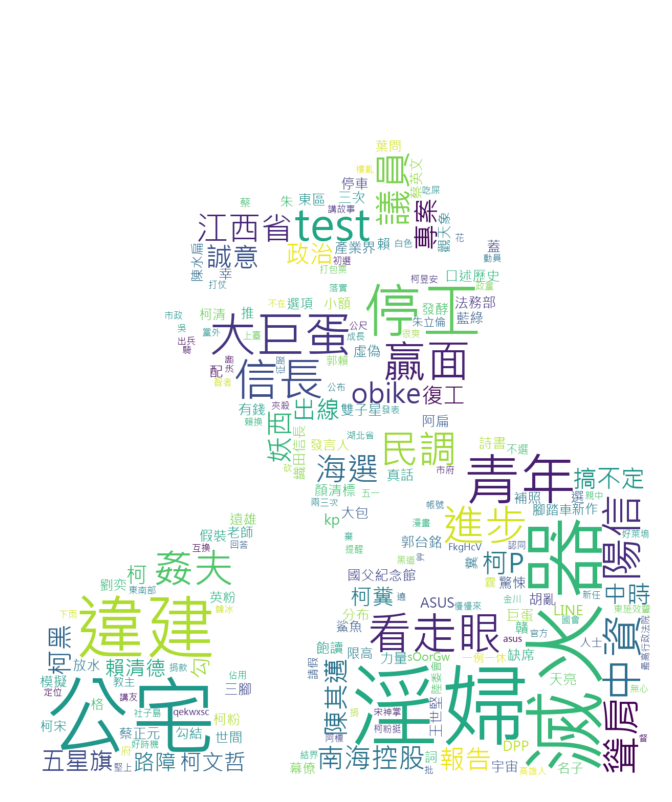

In [14]:
import cv2
#中文繪圖需要中文字體，請自己從windows font目錄抓
#微軟正黑體
font = '../asset/black.ttf'
#想要文字雲出現的圖示
mask = np.array(Image.open("../asset/kop.jpg"))
ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY_INV)
#背景顏色預設黑色，改為白色
#mark改用五月天的皇冠
#其他參數請自行參考wordcloud
my_wordcloud = WordCloud(background_color="white",mask=mask,font_path=font,collocations=False, width=mask.shape[1], height=mask.shape[0], margin=2)  
my_wordcloud.generate_from_frequencies(frequencies=global_tfidf)
 
#產生圖片
#plt.figure( figsize=(10,10))
plt.imshow(my_wordcloud,interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=-25)
#顯示用
plt.savefig(path_pdf,dpi=600,bbox_inches="tight")
plt.show()
